In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle

import sys
sys.path.insert(0, '/Users/andrewandmatthewfonseca/NWelch/src/')

import TimeSeries
import Bivariate as Bi

In [2]:
# Fonts and Sizes
title_font = 18
label_font = 14
text_font = 12
figsize = (9, 5)

In [3]:
data = pd.read_csv('HD20794_HARPS_Feng17.txt', delim_whitespace=True, comment='#')
data

,RJD,RV,e_RV,BIS,FWHM,Halpha,logR'(HK),NaD1,NaD2,3AP2-1,...,6AP5-4,6AP6-5,9AP2-1,9AP3-2,9AP4-3,9AP5-4,9AP6-5,9AP7-6,9AP8-7,9AP9-8
0,53571.92932,-3.54130,0.38257,-41.67402,6.38962,0.16833,0.96511,0.70038,0.49035,3.39352,...,3.07913,2.13056,-2.25731,1.68105,3.70944,-0.20450,-2.26730,3.35641,0.65005,3.58131
1,53571.93408,-3.76917,0.41364,-41.01080,6.39146,0.16774,0.96602,0.70225,0.49138,1.93219,...,-1.04907,4.48251,0.41171,0.28990,1.32489,1.54338,-1.77583,-1.45835,5.15898,0.83355
2,53571.93854,-4.43531,0.39294,-41.18059,6.39094,0.16735,0.96642,0.70151,0.49181,3.67808,...,1.12875,5.23736,0.97792,2.41222,1.78039,0.96703,0.16103,0.01386,3.54310,5.73817
3,53571.94239,-4.86209,0.38001,-41.47111,6.38986,0.16692,0.96633,0.70080,0.49251,2.91127,...,-1.31392,6.16297,-1.26338,2.31786,0.67180,1.91097,0.44848,-2.04767,3.62819,4.24236
4,53571.94634,-3.12528,0.39686,-41.93214,6.38907,0.16795,0.96531,0.70026,0.49187,3.87870,...,3.14394,1.74174,-1.16608,-0.18713,4.04659,0.47915,-0.73155,2.66149,-0.43096,4.67923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4878,56538.88169,-3.33677,0.32452,-42.40044,6.40951,0.16493,0.96819,0.70184,0.49811,3.37944,...,-0.35830,5.62643,6.20488,-0.68742,3.68681,0.56467,-3.11838,0.73634,1.88982,4.33900
4879,56564.76211,-3.41550,0.28242,-43.30241,6.41245,0.16540,0.96833,0.70314,0.49066,-0.30794,...,3.41633,0.55355,0.57263,0.43058,-0.01826,-1.58113,1.41791,2.73226,-3.13380,7.01151
4880,56564.76479,-3.97736,0.27438,-42.41135,6.41290,0.16586,0.96900,0.70201,0.48989,0.18912,...,2.42535,-0.96201,2.17649,0.47312,-0.44202,-0.48194,1.35256,1.89994,-3.40059,4.64229
4881,56564.76738,-3.53729,0.29427,-40.30742,6.41489,0.16642,0.96906,0.70254,0.49128,0.87593,...,0.46555,1.34238,3.76880,-1.86315,0.74373,0.07357,1.38032,-0.28740,0.36095,2.30413


In [4]:
# Stellar signals
pb = 18.33 # planet b
pc = 43.17 # planet c (possible)
pld = 88.90 # planet d (Changed to not conflict with pandas import)
pe = 147.02 # planet e
pf = 331.41 # planet f (possible)
pg = 11.86 # planet g (possible)

p1 = 7.5 # relevant signal (from horizontal line plot)
p2 = 29.5 # Moon phase
p3 = 365.25 # Earth orbit (originally I had written 395.25 as a mistake)
# Harmonics of 7.5
p4 = 15 # 2nd harmonic
p5 = 22.5 # 3rd harmonic
p6 = 30 # 4th harmonic

In [5]:
# Arrays for loops
planets = [1/pb, 1/pc, 1/pld, 1/pe, 1/pf, 1/pg, 1/33]
planets2 = [1/p1, 1/p2, 1/p3, 1/p4, 1/p5, 1/p6]
planet_labels = ['b (1/18.33)', 'c (1/43.17)', 'd (1/88.90)', 'e (1/147.02)', 'f (1/331.41)', 'g (1/11.86)', '1/33']
planet_labels2 = ['1 (1/7.5)', '2 (1/29.5)', '3 (1/365.25)', '4 (1/15)', '5 (1/22.5)', '6 (1/30)']
color_array = ['red', 'blue', 'green', 'orange', 'purple', 'royalblue', 'magenta']

In [6]:
# Function for vertical lines
def freq_vlines():
    for p, p_l, c_a in zip(planets, planet_labels, color_array):
        plt.axvline(p, linestyle='--', color=c_a, alpha=0.7, label=p_l)
    plt.legend(loc='upper right', fontsize='small')
    plt.show()

In [7]:
# Function for vertical lines
def freq_vlines2():
    for p2, p_l2, c_a in zip(planets2, planet_labels2, color_array):
        plt.axvline(p2, linestyle='--', color=c_a, alpha=0.7, label=p_l2)
    plt.legend(loc='upper right', fontsize='small')
    plt.show()

<font size=10><p style="text-align:center"> RV & logR'(HK) (Three-Segmentation) </font></p>

In [8]:
logr = TimeSeries.TimeSeries(data['RJD'].to_numpy(), data["logR'(HK)"].to_numpy())
rv = TimeSeries.TimeSeries(data['RJD'].to_numpy(), data['RV'].to_numpy(), display_frequency_info=False)
print("# of rows in dataset: ", logr.N)

Nyquist frequency from mean dt: 0.81561
Nyquist frequency from 10% trimmed mean dt: 15.88007
Nyquist frequency from 20% trimmed mean dt: 90.33436
Nyquist frequency from median dt: 326.79739
Rayleigh resolution: 0.00033
# of rows in dataset:  4883


<Axes: xlabel='RJD', ylabel='RV'>

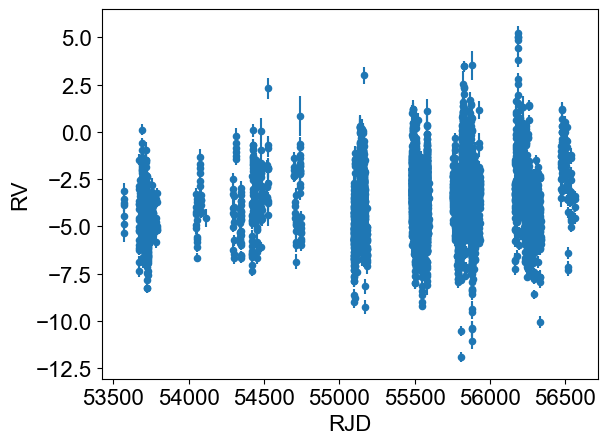

In [9]:
# Scatter plot with errorbars
# There are more points present then before; possibly more data from recent observation?)
data.plot.scatter(x='RJD', y='RV', yerr='e_RV')

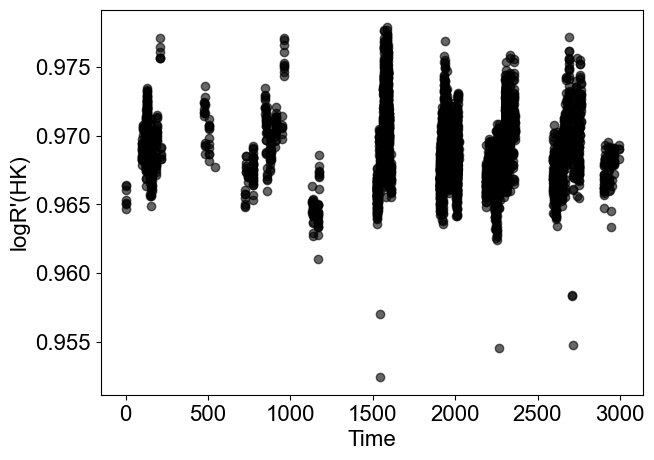

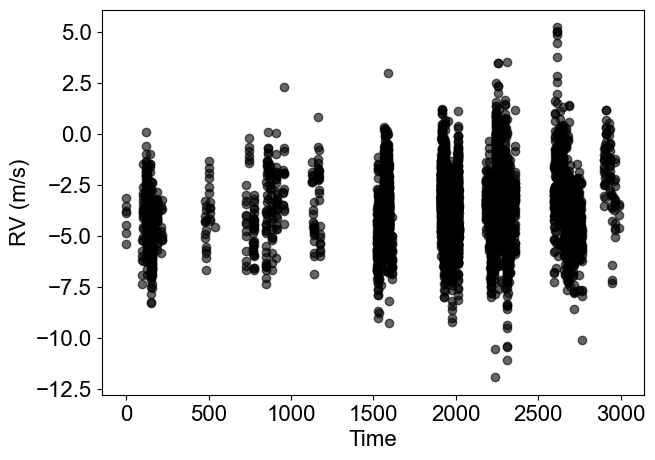

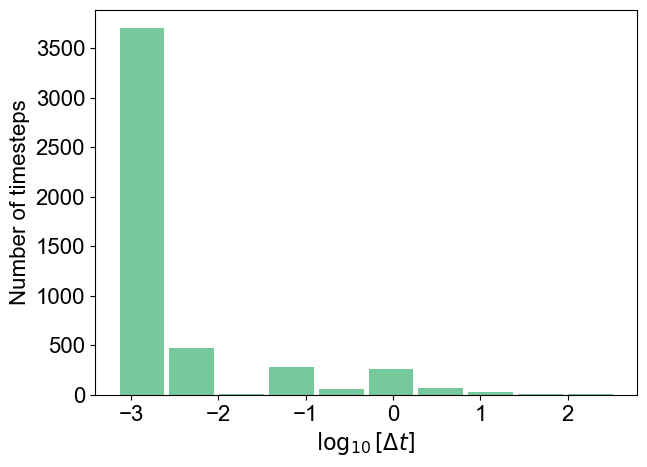

In [10]:
logr.scatterplot(ylabel="logR'(HK)")
rv.scatterplot(ylabel="RV (m/s)")
rv.dthist()

In [11]:
logr.frequency_grid(0.5, 3)
rv.frequency_grid(0.5, 3)

logr.pow_FT(N_bootstrap=1000)
rv.pow_FT(N_bootstrap=1000)

Iteration 0
Iteration 500
Iteration 0
Iteration 500


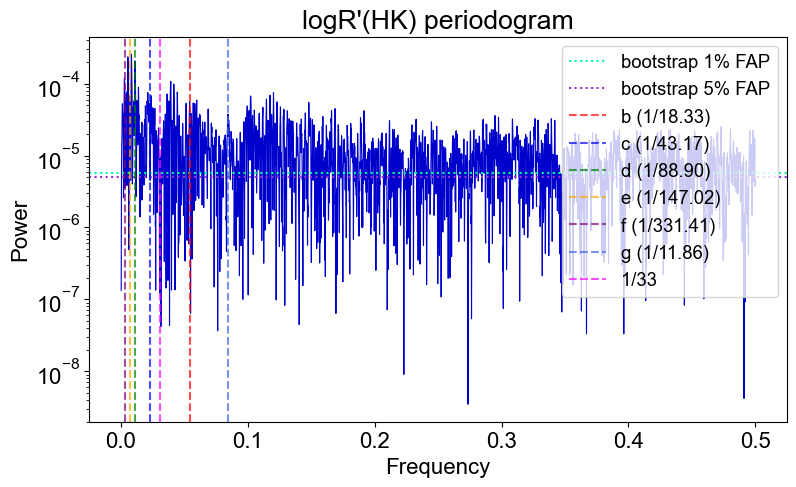

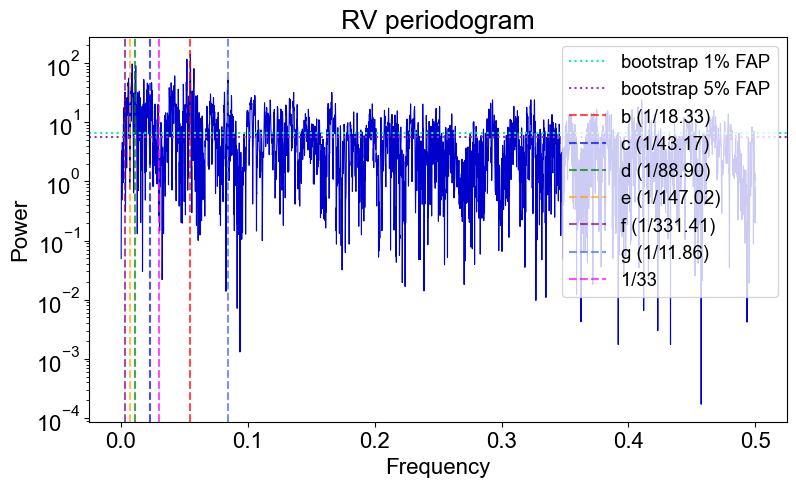

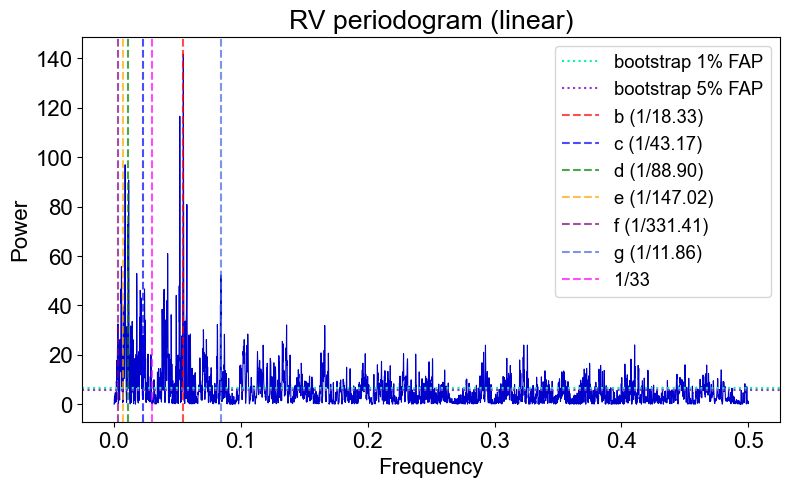

In [12]:
logr.powplot(title="logR'(HK) periodogram")
freq_vlines()
rv.powplot(title='RV periodogram')
freq_vlines()
rv.powplot(title='RV periodogram (linear)', yscale='linear')
freq_vlines()

In [13]:
rv.Siegel_test()
logr.Siegel_test()

T statistic: 0.03402
T threshold for rejecting white noise hypothesis at 5% level: 0.00235
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities
T statistic: 0.03291
T threshold for rejecting white noise hypothesis at 5% level: 0.00235
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


In [14]:
rv_logr = Bi.Bivariate(data['RJD'].to_numpy(), data['RV'].to_numpy(), data["logR'(HK)"].to_numpy())

Nyquist frequency from mean dt: 0.81561
Nyquist frequency from 10% trimmed mean dt: 15.88007
Nyquist frequency from 20% trimmed mean dt: 90.33436
Nyquist frequency from median dt: 326.79739
Rayleigh resolution: 0.00033


In [15]:
# We try to find the best boundaries to use for the segmentation.

# Two-segments
two_seg1_logr = np.where(rv_logr.x_series.t < 2150)[0] # Used 1250 and 1750 before
two_seg2_logr = np.where(rv_logr.x_series.t > 2150)[0] # Used 1250 and 1750 before

print(two_seg1_logr[0], two_seg1_logr[-1])
print(two_seg2_logr[0], two_seg2_logr[-1])

0 2786
2787 4882


In [16]:
# Three-segments
three_seg1_logr = np.where(rv_logr.x_series.t < 1750)[0]
three_seg2_logr = np.where((rv_logr.x_series.t > 1750) & (rv_logr.x_series.t < 2150))[0]
three_seg3_logr = np.where(rv_logr.x_series.t > 2150)[0]

print(three_seg1_logr[0], three_seg1_logr[-1])
print(three_seg2_logr[0], three_seg2_logr[-1])
print(three_seg3_logr[0], three_seg3_logr[-1])

0 1484
1485 2786
2787 4882


In [17]:
# Four-segments
four_seg1_logr = np.where(rv_logr.x_series.t < 1250)[0]
four_seg2_logr = np.where((rv_logr.x_series.t > 1250) & (rv_logr.x_series.t < 2150))[0]
four_seg3_logr = np.where((rv_logr.x_series.t > 2150) & (rv_logr.x_series.t < 2400))[0]
four_seg4_logr = np.where(rv_logr.x_series.t > 2400)[0]

print(four_seg1_logr[0], four_seg1_logr[-1])
print(four_seg2_logr[0], four_seg2_logr[-1])
print(four_seg3_logr[0], four_seg3_logr[-1])
print(four_seg4_logr[0], four_seg4_logr[-1])

0 702
703 2786
2787 4162
4163 4882


In [18]:
two_segs_logr = np.array([[0, 2786], [2787, 4882]])
three_segs_logr = np.array([[0, 1484], [1485, 2786], [2787, 4882]]) #Old Array = np.array([[0,702], [703,2786], [2786,4882]])
four_segs_logr = np.array([[0, 702], [703, 2786], [2787, 4162], [4163, 4882]])

Number of segments: 3
Segment start and end points: [[   0 1484]
 [1485 2786]
 [2787 4882]]
Effective number of segments: 3.000000
Frequency grid spacing: 0.000104
Minimum 6-dB main lobe half width: 0.000750
Mean 6-dB main lobe half width (1/2 resolution limit): 0.003729
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000620
Number of segments: 3
Segment start and end points: [[   0 1484]
 [1485 2786]
 [2787 4882]]
Effective number of segments: 3.000000
Frequency grid spacing: 0.000104
Minimum 6-dB main lobe half width: 0.000750
Mean 6-dB main lobe half width (1/2 resolution limit): 0.003729
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000620


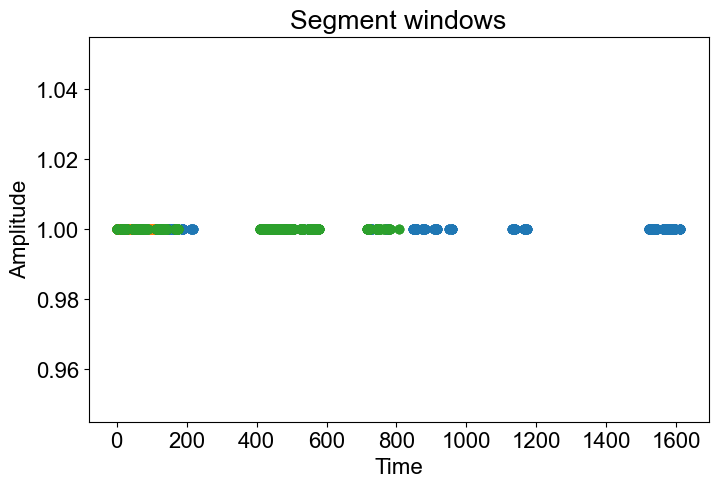

In [19]:
#rv_ha.segment_data(2, 0.2, oversample=6, window='BlackmanHarris', plot_windows=True)


#rv_ha.segment_data(two_segs, 0.2, oversample=6, plot_windows=True)
rv_logr.segment_data(three_segs_logr, 0.2, oversample=6, plot_windows=True)
#rv_ha.segment_data(four_segs, 0.2, oversample=6, plot_windows=True)

# The window is the taper, the first value is the number of segments.
# Create more instances of segmentation and tapering (2, 3, 4 segments; with and without taper).
# Create manual segment boundaries.
# continue without the taper window

In [20]:
rv_logr.Welch_coherence_powspec()
#rv_ha.Welch_coherence_powspec_bootstrap()
# For analytical data, the bootstrap isn't necessary, as it is useful for non-analytical data to estimate the distribution of relevant statistics.

In [21]:
rv_logr.Siegel_Welch()

Siegel's test on Sxx:
T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00433
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
Siegel's test on Syy:
T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00433
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)


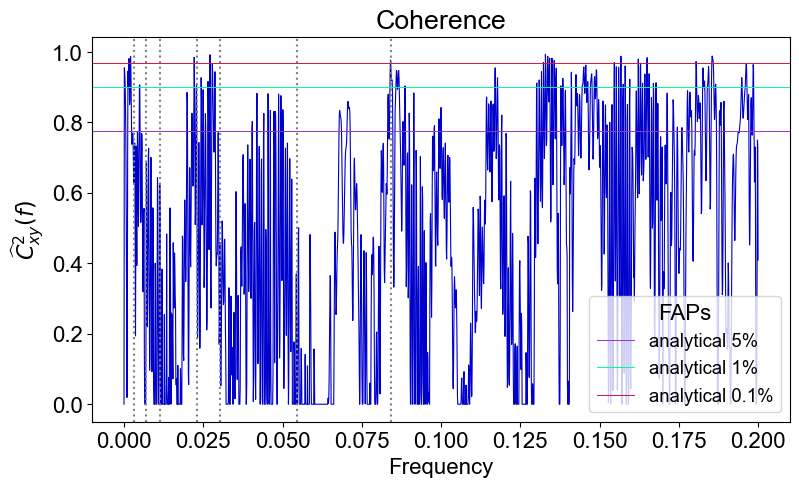

In [22]:
rv_logr.coh_plot(show_theoretical_thresholds=True, vlines=planets)

0.1672316384180791 0.09943502824858758 0.13607118412046543 0.13059548254620124


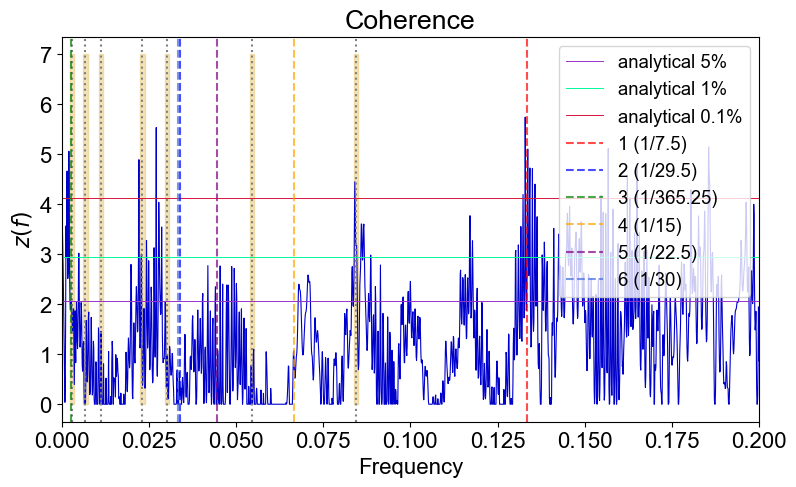

In [23]:
rv_logr.coh_plot(transformed=True, vlines=planets, show_theoretical_thresholds=True, show_boot_thresholds=False)

rayleigh = 0.000620 # Best-case rayleight resolution limit
for i in planets:
    plt.fill_between([i - rayleigh, i + rayleigh], [0,0], [7, 7], color='goldenrod', alpha=0.3)

plt.xlim(0, 0.2)

# Finding peaks above a FAP threshold of 1%
x = rv_logr.pow_coh_grid
y = rv_logr.coh_transformed

prob1 = Bi.ztrans(rv_logr.coh_prob_1, rv_logr.Nseg_eff) # Change the coh_prob_x depending on FAP probability threshold
peak1 = x[y > prob1]
filtered_peaks1 = peak1[peak1 <= 0.1]

# Interactions of Moon phase, Earth rotation, and 7.5 day signal
add1 = 1/p1 + 1/p2
sub1 = 1/p1 - 1/p2
add2 = 1/p1 + 1/p3
sub2 = 1/p1 - 1/p3
print(add1, sub1, add2, sub2)

# Print vertical lines of related signals
freq_vlines2()


#for i in filtered_peaks1:
#    plt.axvline(i, alpha=0.3, ls='--')

#np.set_printoptions(suppress=True)
#print(filtered_peaks1)

# To save array with peaks into a file
#df = pd.DataFrame(filtered_peaks1)
#df.to_csv("rv_logr_best_prob1_3segs.csv", index=False, header=False)

In [24]:
# Interactions of Moon phase, Earth rotation, and 7.5 day signal
add1 = 1/p1 + 1/p2
sub1 = 1/p1 - 1/p2
add2 = 1/p1 + 1/p3
sub2 = 1/p1 - 1/p3
print(add1, sub1, add2, sub2)

0.1672316384180791 0.09943502824858758 0.13607118412046543 0.13059548254620124


In [25]:
# Differentiating 43 day, 39 day, and 33 day signals using Rayleigh resolution
p7 = 43
p8 = 39
p9 = 33
diff1 = np.abs(1/p7 - 1/p8) > 2*0.00033
diff2 = np.abs(1/p8 - 1/p9) > 2*0.00033
print(diff1, diff2)
# 0.00033 is the rayleigh resolution of this coherence of logR(HK)

True True


[0.00010352 0.00020704 0.00031056 0.00124224 0.00144928 0.0015528
 0.00165631 0.00196687 0.00207039 0.00217391 0.00486542 0.00496894
 0.02204969 0.02215321 0.02287785 0.02432712 0.02650104 0.02712215
 0.02784679 0.02795031 0.02867495 0.08395445 0.08405797 0.08416149
 0.08426501 0.08436853 0.08447205 0.08457557 0.08581781 0.08592133
 0.08602484 0.08612836 0.08643892 0.08654244 0.08664596 0.08674948
 0.08861284]


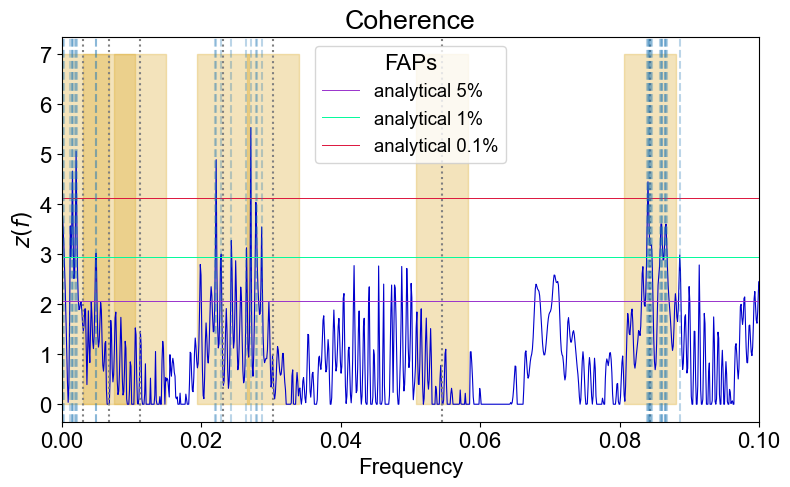

In [26]:
rv_logr.coh_plot(transformed=True, vlines=planets, show_theoretical_thresholds=True, show_boot_thresholds=False)

rayleigh = 0.003729
for i in planets:
    plt.fill_between([i - rayleigh, i + rayleigh], [0,0], [7, 7], color='goldenrod', alpha=0.3)

plt.xlim(0, 0.1)

# Finding peaks above a FAP threshold of 1%
x = rv_logr.pow_coh_grid
y = rv_logr.coh_transformed

prob1 = Bi.ztrans(rv_logr.coh_prob_1, rv_logr.Nseg_eff) # Change the coh_prob_x depending on FAP probability threshold
peak1 = x[y > prob1]
filtered_peaks1 = peak1[peak1 <= 0.1]


for i in filtered_peaks1:
    plt.axvline(i, alpha=0.3, ls='--')

np.set_printoptions(suppress=True)
print(filtered_peaks1)

# To save array with peaks into a file
df = pd.DataFrame(filtered_peaks1)
df.to_csv("rv_logr_realistic_prob1_3segs.csv", index=False, header=False)

Half bandwidth: 0.001282
Welch average spectral window not saved to file
Half bandwidth: 0.001282
Welch average spectral window not saved to file


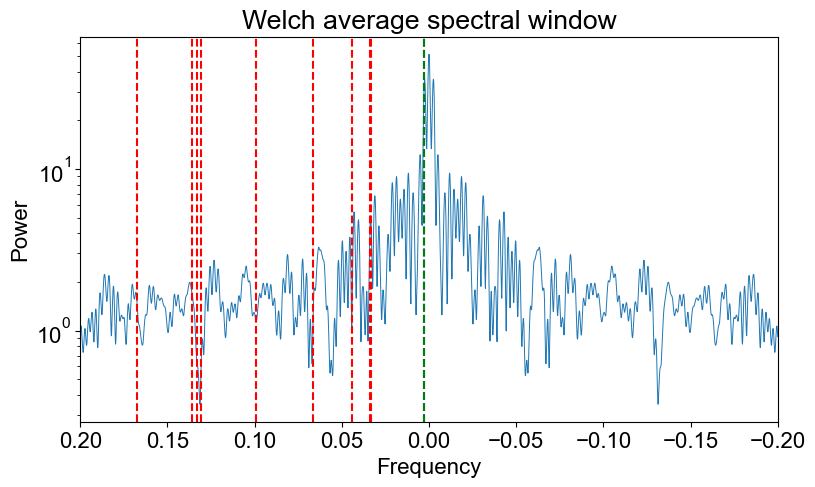

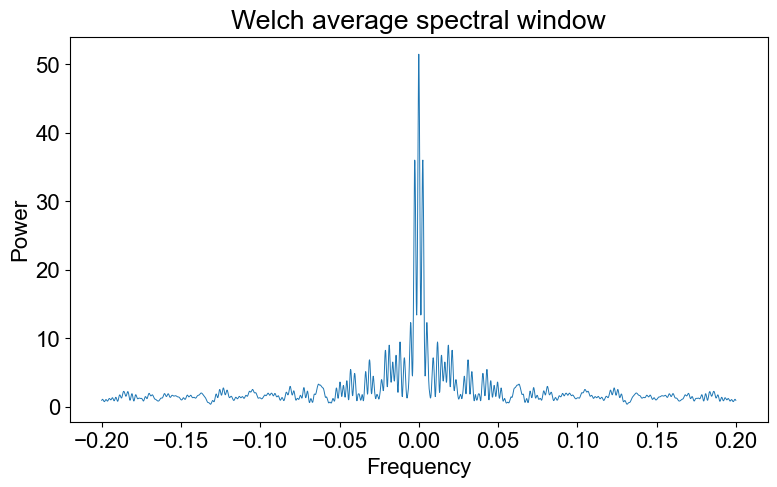

In [61]:
rv_logr.x_series.spectral_window_Welch()
plt.xlim(0.2, -0.2)
add1 = 1/7.5 + 1/29.5
add2 = 1/7.5 - 1/29.5
sub1 = 1/7.5 + 1/395.25
sub2 = 1/7.5 - 1/395.25
plt.axvline(x=1/15, linestyle='--', color='red')
plt.axvline(x=1/22.5, linestyle='--', color='red')
plt.axvline(x=1/30, linestyle='--', color='red')
plt.axvline(x=add1, linestyle='--', color='red')
plt.axvline(x=add2, linestyle='--', color='red')
plt.axvline(x=sub1, linestyle='--', color='red')
plt.axvline(x=sub2, linestyle='--', color='red')
plt.axvline(x=1/7.5, linestyle='--', color='red')
plt.axvline(x=1/29.5, linestyle='--', color='red')
plt.axvline(x=1/365.25, linestyle='--', color='blue')
plt.axvline(x=1/pf, linestyle='--', color='green')
rv_logr.x_series.spectral_window_Welch(yscale='linear')
# clean this up; harmonics of 7.5 and other signals

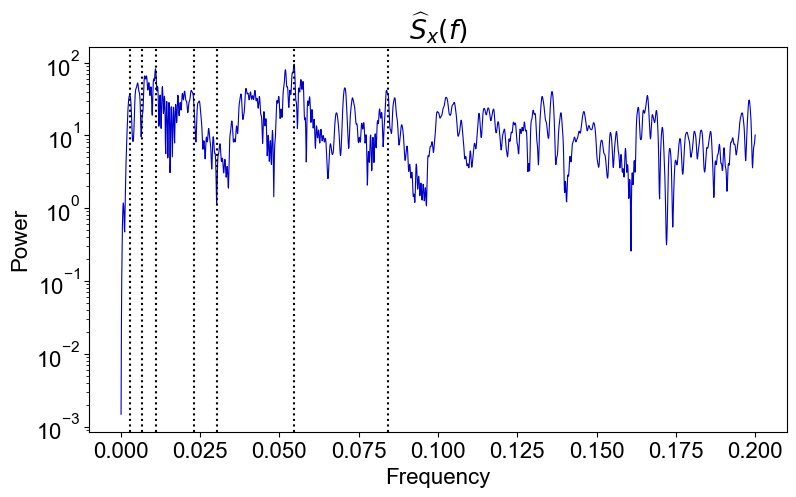

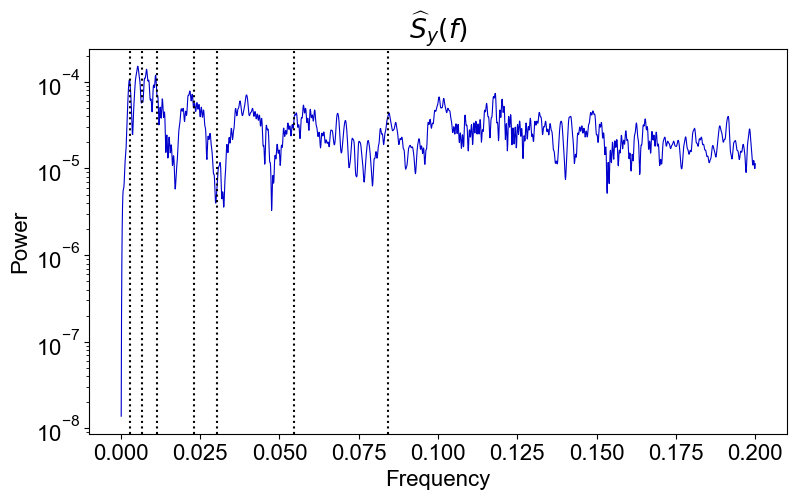

In [28]:
rv_logr.Welch_pow_plot(vlines=planets)
rv_logr.Welch_pow_plot(x_or_y='y', vlines=planets)

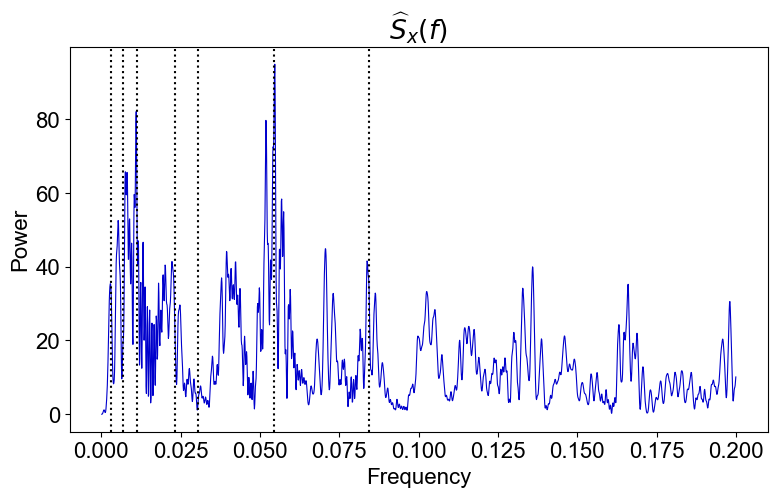

In [29]:
rv_logr.Welch_pow_plot(vlines=planets, yscale='linear')

In [30]:
pow_logr = LombScargle(data['RJD'].to_numpy(), data["logR'(HK)"].to_numpy(), normalization='psd').power(rv_logr.pow_coh_grid)
pow_rv = LombScargle(data['RJD'].to_numpy(), data['RV'].to_numpy(), normalization='psd').power(rv_logr.pow_coh_grid)

/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:102: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))


In [31]:
frot_measured = rv_logr.y_series.Welch_powgrid[np.argmax(rv_logr.y_series.Welch_pow)]
print('Measured rotation period:', 1/frot_measured)

Measured rotation period: 189.4117647058826


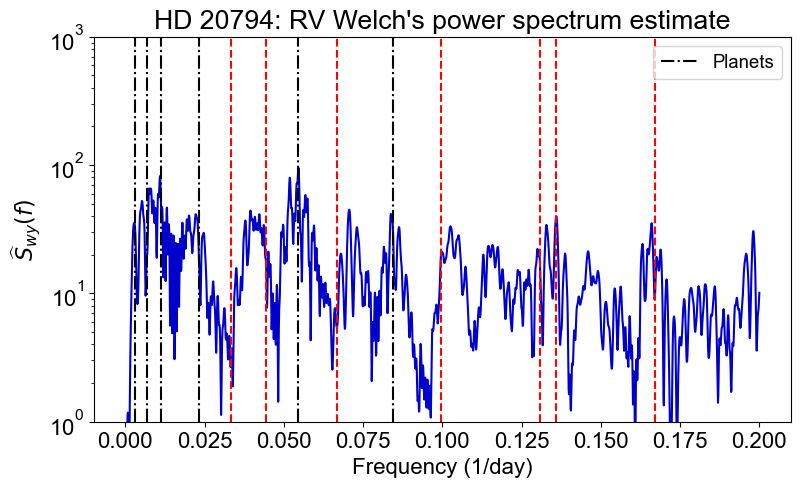

In [32]:
plt.figure(figsize=figsize)
plt.semilogy(rv_logr.pow_coh_grid, rv_logr.x_series.Welch_pow, color='mediumblue')
#plt.axhline(rv_ha.xpow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
#plt.axhline(rv_ha.xpow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
#plt.axhline(rv_ha.xpow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')

for n in range(6):
    if n == 0:
        plt.axvline(planets[n], color='k', ls='-.', label='Planets')
    else:
        plt.axvline(planets[n], color='k', ls='-.')
        
    
plt.ylim(1, 1e3)
plt.axvline(x=1/15, linestyle='--', color='red')
plt.axvline(x=1/22.5, linestyle='--', color='red')
plt.axvline(x=1/30, linestyle='--', color='red')
plt.axvline(x=add1, linestyle='--', color='red')
plt.axvline(x=add2, linestyle='--', color='red')
plt.axvline(x=sub1, linestyle='--', color='red')
plt.axvline(x=sub2, linestyle='--', color='red')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wy}(f)$")
plt.title(r"HD 20794: RV Welch's power spectrum estimate")
plt.legend(loc='upper right', fontsize='small')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


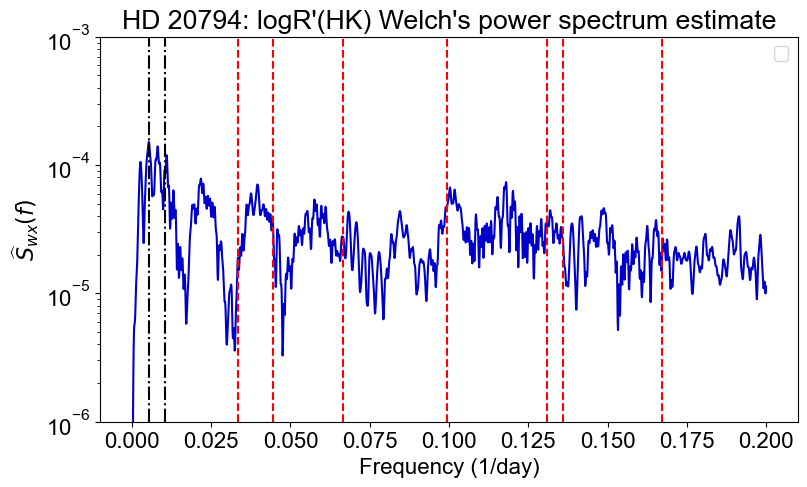

In [33]:
plt.figure(figsize=figsize)
plt.semilogy(rv_logr.pow_coh_grid, rv_logr.y_series.Welch_pow, color='mediumblue')
#plt.axhline(rv_logr.ypow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
#plt.axhline(rv_logr.ypow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
#plt.axhline(rv_logr.ypow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')

for s in [frot_measured, 2*frot_measured]:
    plt.axvline(s, color='k', ls='-.')
    
plt.ylim(1e-6, 1e-3)
plt.axvline(x=1/15, linestyle='--', color='red')
plt.axvline(x=1/22.5, linestyle='--', color='red')
plt.axvline(x=1/30, linestyle='--', color='red')
plt.axvline(x=add1, linestyle='--', color='red')
plt.axvline(x=add2, linestyle='--', color='red')
plt.axvline(x=sub1, linestyle='--', color='red')
plt.axvline(x=sub2, linestyle='--', color='red')
#plt.axvline(3*frot_measured, color='k', ls='-.', label='meas. rotation and harmonics')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wx}(f)$")
plt.title(r"HD 20794: logR'(HK) Welch's power spectrum estimate")
plt.legend(loc='upper right', fontsize='small')

<font size=7><p style="text-align:center"> RV & logR'(HK) (Two-Segmentation) </font></p>

Number of segments: 2
Segment start and end points: [[   0 2786]
 [2787 4882]]
Effective number of segments: 2.000000
Frequency grid spacing: 0.000083
Minimum 6-dB main lobe half width: 0.000599
Mean 6-dB main lobe half width (1/2 resolution limit): 0.000985
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000495
Number of segments: 2
Segment start and end points: [[   0 2786]
 [2787 4882]]
Effective number of segments: 2.000000
Frequency grid spacing: 0.000083
Minimum 6-dB main lobe half width: 0.000599
Mean 6-dB main lobe half width (1/2 resolution limit): 0.000985
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000495


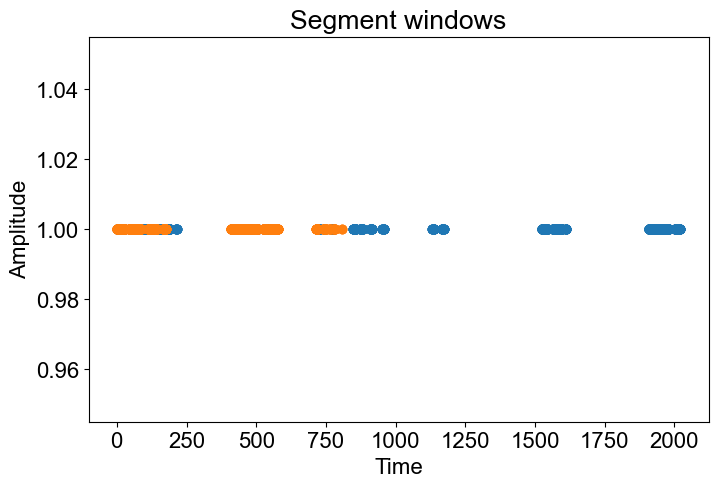

In [34]:
#rv_ha.segment_data(2, 0.2, oversample=6, window='BlackmanHarris', plot_windows=True)


#rv_ha.segment_data(two_segs, 0.2, oversample=6, plot_windows=True)
rv_logr.segment_data(two_segs_logr, 0.2, oversample=6, plot_windows=True)
#rv_ha.segment_data(four_segs, 0.2, oversample=6, plot_windows=True)

# The window is the taper, the first value is the number of segments.
# Create more instances of segmentation and tapering (2, 3, 4 segments; with and without taper).
# Create manual segment boundaries.
# continue without the taper window

In [35]:
rv_logr.Welch_coherence_powspec()
#rv_ha.Welch_coherence_powspec_bootstrap()
# For analytical data, the bootstrap isn't necessary, as it is useful for non-analytical data to estimate the distribution of relevant statistics.

In [36]:
rv_logr.Siegel_Welch()

Siegel's test on Sxx:
T statistic: 0.00215
T threshold for rejecting white noise hypothesis at 5% level: 0.00367
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
Siegel's test on Syy:
T statistic: 0.00382
T threshold for rejecting white noise hypothesis at 5% level: 0.00367
Null hypothesis rejected: 95% chance this time series has 1 or more periodicities


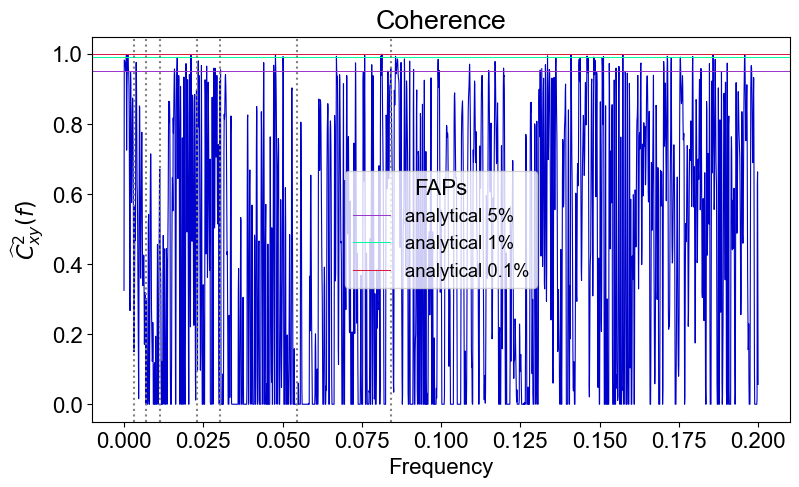

In [37]:
rv_logr.coh_plot(show_theoretical_thresholds=True, vlines=planets)

[0.00074257 0.00123762 0.01674917 0.02112211 0.04777228 0.05016502
 0.0669967  0.07590759 0.0810231  0.08135314 0.08564356]


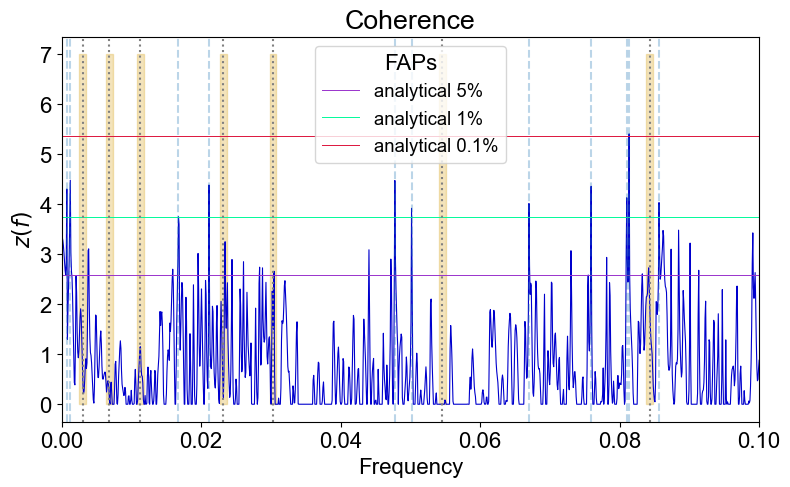

In [38]:
rv_logr.coh_plot(transformed=True, vlines=planets, show_theoretical_thresholds=True, show_boot_thresholds=False)

rayleigh = 0.000495 # Best-case rayleight resolution limit
for i in planets:
    plt.fill_between([i - rayleigh, i + rayleigh], [0,0], [7, 7], color='goldenrod', alpha=0.3)

plt.xlim(0, 0.1)

# Finding peaks above a FAP threshold of 1%
x = rv_logr.pow_coh_grid
y = rv_logr.coh_transformed

prob1 = Bi.ztrans(rv_logr.coh_prob_1, rv_logr.Nseg_eff) # Change the coh_prob_x depending on FAP probability threshold
peak1 = x[y > prob1]
filtered_peaks1 = peak1[peak1 <= 0.1]


for i in filtered_peaks1:
    plt.axvline(i, alpha=0.3, ls='--')

np.set_printoptions(suppress=True)
print(filtered_peaks1)

# To save array with peaks into a file
df = pd.DataFrame(filtered_peaks1)
df.to_csv("rv_logr_best_prob1_2segs.csv", index=False, header=False)

[0.00074257 0.00123762 0.01674917 0.02112211 0.04777228 0.05016502
 0.0669967  0.07590759 0.0810231  0.08135314 0.08564356]


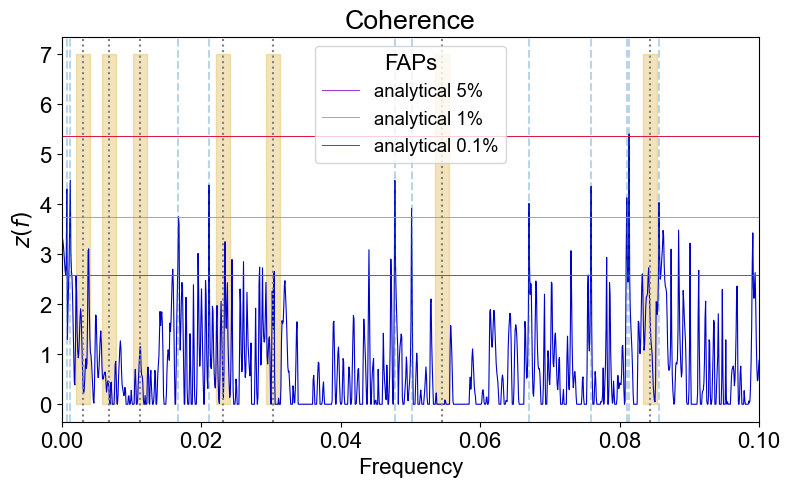

In [39]:
rv_logr.coh_plot(transformed=True, vlines=planets, show_theoretical_thresholds=True, show_boot_thresholds=False)

rayleigh = 0.000985
for i in planets:
    plt.fill_between([i - rayleigh, i + rayleigh], [0,0], [7, 7], color='goldenrod', alpha=0.3)

plt.xlim(0, 0.1)

# Finding peaks above a FAP threshold of 1%
x = rv_logr.pow_coh_grid
y = rv_logr.coh_transformed

prob1 = Bi.ztrans(rv_logr.coh_prob_1, rv_logr.Nseg_eff) # Change the coh_prob_x depending on FAP probability threshold
peak1 = x[y > prob1]
filtered_peaks1 = peak1[peak1 <= 0.1]


for i in filtered_peaks1:
    plt.axvline(i, alpha=0.3, ls='--')

np.set_printoptions(suppress=True)
print(filtered_peaks1)

# To save array with peaks into a file
df = pd.DataFrame(filtered_peaks1)
df.to_csv("rv_logr_realistic_prob1_2segs.csv", index=False, header=False)

Half bandwidth: 0.003300
Welch average spectral window not saved to file
Half bandwidth: 0.003300
Welch average spectral window not saved to file


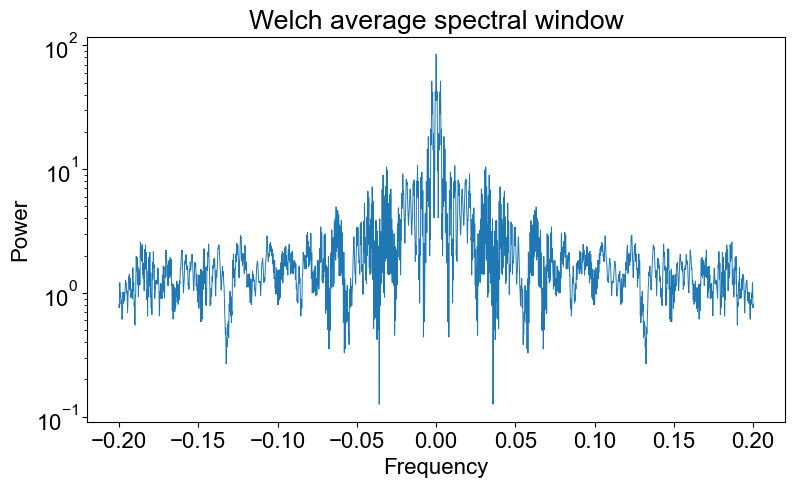

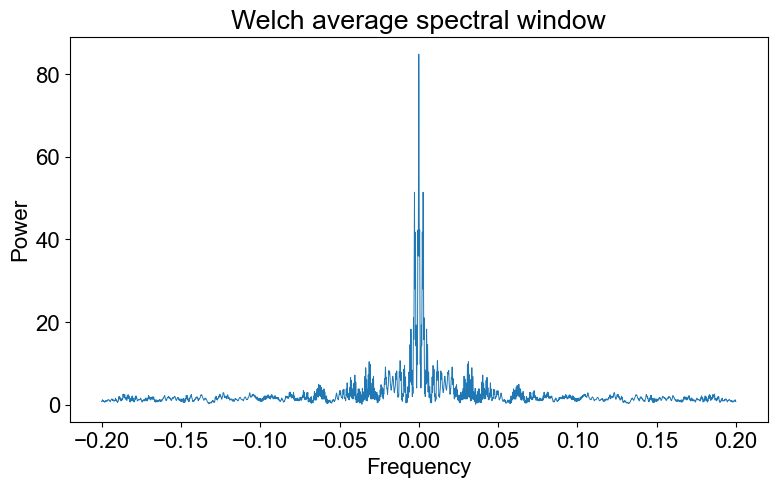

In [40]:
rv_logr.x_series.spectral_window_Welch()
rv_logr.x_series.spectral_window_Welch(yscale='linear')

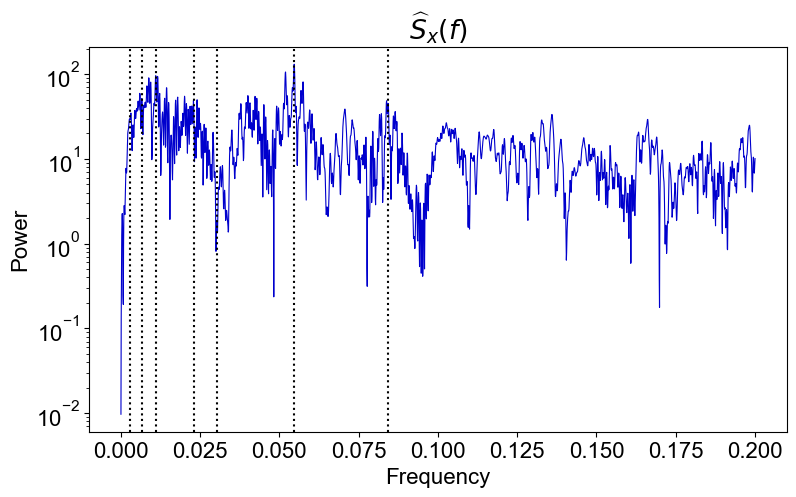

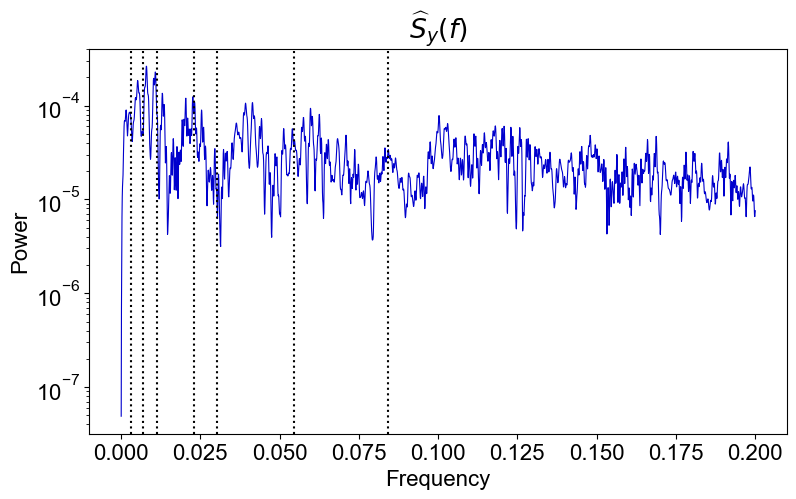

In [41]:
rv_logr.Welch_pow_plot(vlines=planets)
rv_logr.Welch_pow_plot(x_or_y='y', vlines=planets)

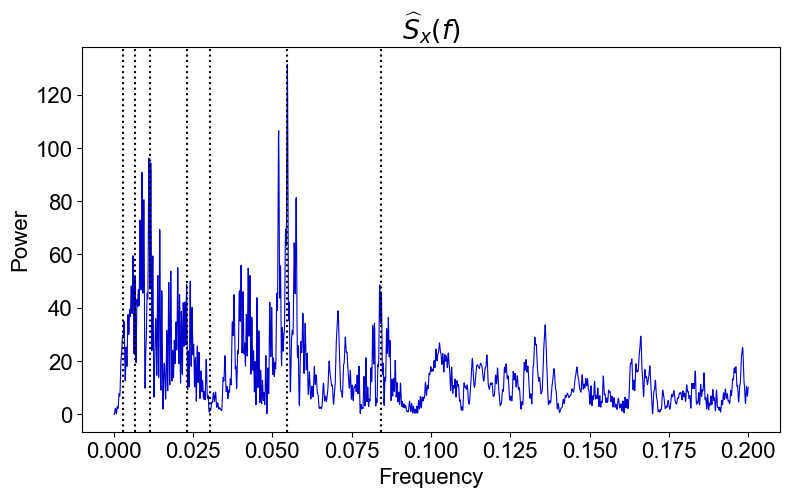

In [42]:
rv_logr.Welch_pow_plot(vlines=planets, yscale='linear')

In [43]:
pow_logr = LombScargle(data['RJD'].to_numpy(), data["logR'(HK)"].to_numpy(), normalization='psd').power(rv_logr.pow_coh_grid)
pow_rv = LombScargle(data['RJD'].to_numpy(), data['RV'].to_numpy(), normalization='psd').power(rv_logr.pow_coh_grid)

/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:131: RuntimeWarning: divide by zero encountered in divide
  power = YC * YC / CC + YS * YS / SS
/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:131: RuntimeWarning: invalid value encountered in divide
  power = YC * YC / CC + YS * YS / SS


In [44]:
frot_measured = rv_logr.y_series.Welch_powgrid[np.argmax(rv_logr.y_series.Welch_pow)]
print('Measured rotation period:', 1/frot_measured)

Measured rotation period: 124.9484536082476


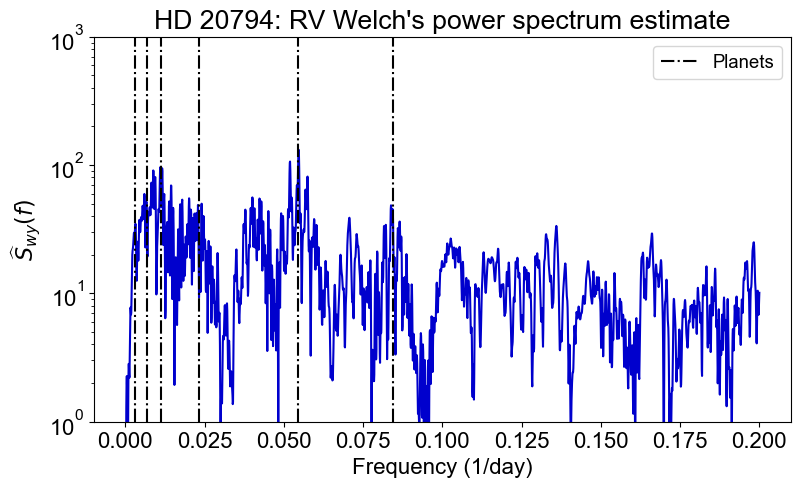

In [45]:
plt.figure(figsize=figsize)
plt.semilogy(rv_logr.pow_coh_grid, rv_logr.x_series.Welch_pow, color='mediumblue')
#plt.axhline(rv_ha.xpow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
#plt.axhline(rv_ha.xpow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
#plt.axhline(rv_ha.xpow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')

for n in range(6):
    if n == 0:
        plt.axvline(planets[n], color='k', ls='-.', label='Planets')
    else:
        plt.axvline(planets[n], color='k', ls='-.')
        
    
plt.ylim(1, 1e3)    
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wy}(f)$")
plt.title(r"HD 20794: RV Welch's power spectrum estimate")
plt.legend(loc='upper right', fontsize='small')

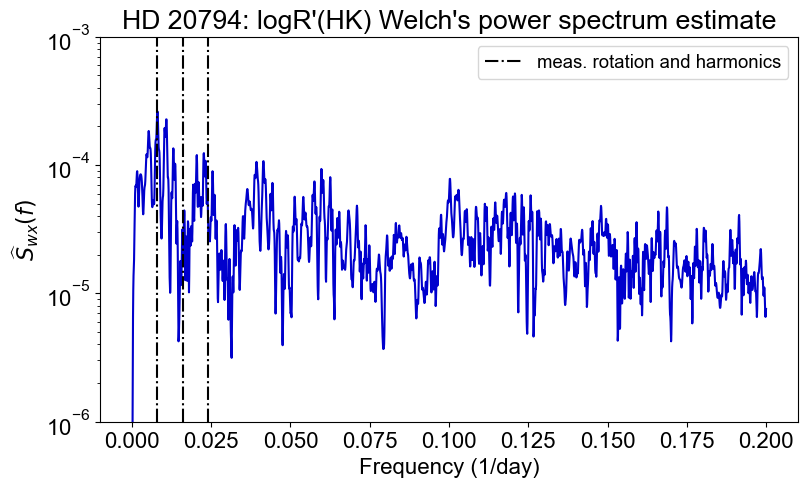

In [46]:
plt.figure(figsize=figsize)
plt.semilogy(rv_logr.pow_coh_grid, rv_logr.y_series.Welch_pow, color='mediumblue')
#plt.axhline(rv_logr.ypow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
#plt.axhline(rv_logr.ypow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
#plt.axhline(rv_logr.ypow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')

for s in [frot_measured, 2*frot_measured]:
    plt.axvline(s, color='k', ls='-.')

plt.ylim(1e-6, 1e-3)
plt.axvline(3*frot_measured, color='k', ls='-.', label='meas. rotation and harmonics')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wx}(f)$")
plt.title(r"HD 20794: logR'(HK) Welch's power spectrum estimate")
plt.legend(loc='upper right', fontsize='small')

<font size=7><p style="text-align:center"> RV & logR'(HK) (Four-Segmentation) </font></p>

Number of segments: 4
Segment start and end points: [[   0  702]
 [ 703 2786]
 [2787 4162]
 [4163 4882]]
Effective number of segments: 4.000000
Frequency grid spacing: 0.000142
Minimum 6-dB main lobe half width: 0.001031
Mean 6-dB main lobe half width (1/2 resolution limit): 0.003574
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000852
Number of segments: 4
Segment start and end points: [[   0  702]
 [ 703 2786]
 [2787 4162]
 [4163 4882]]
Effective number of segments: 4.000000
Frequency grid spacing: 0.000142
Minimum 6-dB main lobe half width: 0.001031
Mean 6-dB main lobe half width (1/2 resolution limit): 0.003574
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.000852


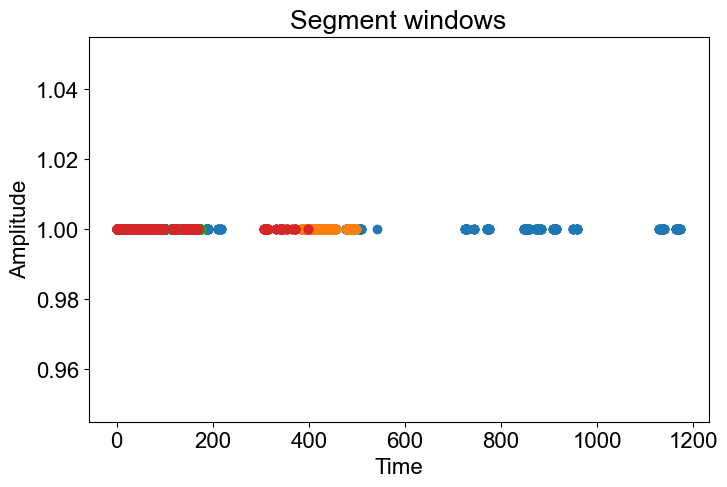

In [47]:
#rv_ha.segment_data(2, 0.2, oversample=6, window='BlackmanHarris', plot_windows=True)


#rv_ha.segment_data(two_segs, 0.2, oversample=6, plot_windows=True)
rv_logr.segment_data(four_segs_logr, 0.2, oversample=6, plot_windows=True)
#rv_ha.segment_data(four_segs, 0.2, oversample=6, plot_windows=True)

# The window is the taper, the first value is the number of segments.
# Create more instances of segmentation and tapering (2, 3, 4 segments; with and without taper).
# Create manual segment boundaries.
# continue without the taper window

In [48]:
rv_logr.Welch_coherence_powspec()
#rv_ha.Welch_coherence_powspec_bootstrap()
# For analytical data, the bootstrap isn't necessary, as it is useful for non-analytical data to estimate the distribution of relevant statistics.

In [49]:
rv_logr.Siegel_Welch()

Siegel's test on Sxx:
T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00545
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
Siegel's test on Syy:
T statistic: 0.00313
T threshold for rejecting white noise hypothesis at 5% level: 0.00545
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)


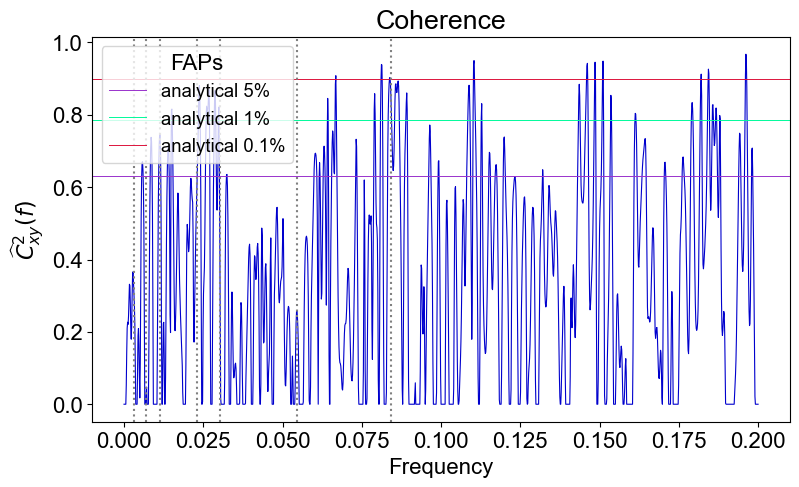

In [50]:
rv_logr.coh_plot(show_theoretical_thresholds=True, vlines=planets)

[0.01495726 0.01509972 0.02350427 0.02364672 0.02378917 0.02393162
 0.02592593 0.02606838 0.02621083 0.02635328 0.02649573 0.02663818
 0.02678063 0.02692308 0.02849003 0.02863248 0.02877493 0.02891738
 0.02977208 0.02991453 0.06424501 0.06438746 0.06666667 0.06680912
 0.06695157 0.07891738 0.07905983 0.07920228 0.08091168 0.08105413
 0.08119658 0.08133903 0.08148148 0.08333333 0.08347578 0.08361823
 0.08376068 0.08390313 0.08404558 0.08418803 0.08433048 0.08547009
 0.08561254 0.08575499 0.08589744 0.08603989 0.08618234 0.08632479
 0.08646724 0.08660969 0.08675214 0.08903134 0.08917379 0.08931624]


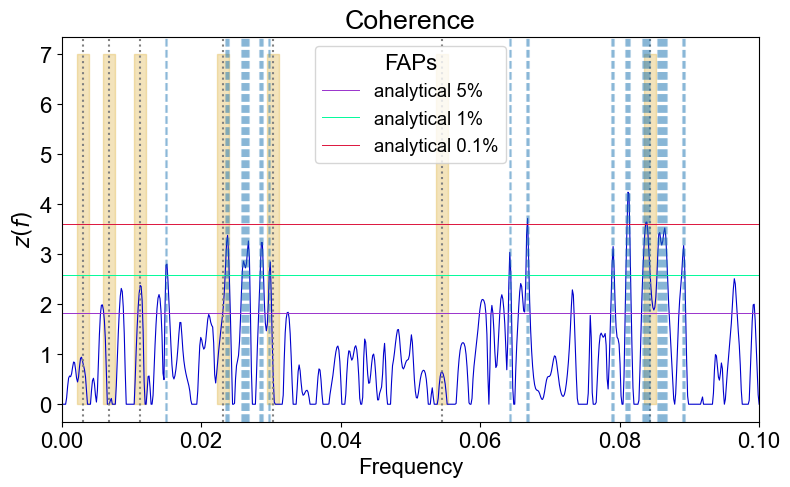

In [51]:
rv_logr.coh_plot(transformed=True, vlines=planets, show_theoretical_thresholds=True, show_boot_thresholds=False)

rayleigh = 0.000852 # Best-case rayleight resolution limit
for i in planets:
    plt.fill_between([i - rayleigh, i + rayleigh], [0,0], [7, 7], color='goldenrod', alpha=0.3)

plt.xlim(0, 0.1)

# Finding peaks above a FAP threshold of 1%
x = rv_logr.pow_coh_grid
y = rv_logr.coh_transformed

prob1 = Bi.ztrans(rv_logr.coh_prob_1, rv_logr.Nseg_eff) # Change the coh_prob_x depending on FAP probability threshold
peak1 = x[y > prob1]
filtered_peaks1 = peak1[peak1 <= 0.1]


for i in filtered_peaks1:
    plt.axvline(i, alpha=0.3, ls='--')

np.set_printoptions(suppress=True)
print(filtered_peaks1)

# To save array with peaks into a file
df = pd.DataFrame(filtered_peaks1)
df.to_csv("rv_logr_best_prob1_4segs.csv", index=False, header=False)

[0.01495726 0.01509972 0.02350427 0.02364672 0.02378917 0.02393162
 0.02592593 0.02606838 0.02621083 0.02635328 0.02649573 0.02663818
 0.02678063 0.02692308 0.02849003 0.02863248 0.02877493 0.02891738
 0.02977208 0.02991453 0.06424501 0.06438746 0.06666667 0.06680912
 0.06695157 0.07891738 0.07905983 0.07920228 0.08091168 0.08105413
 0.08119658 0.08133903 0.08148148 0.08333333 0.08347578 0.08361823
 0.08376068 0.08390313 0.08404558 0.08418803 0.08433048 0.08547009
 0.08561254 0.08575499 0.08589744 0.08603989 0.08618234 0.08632479
 0.08646724 0.08660969 0.08675214 0.08903134 0.08917379 0.08931624]


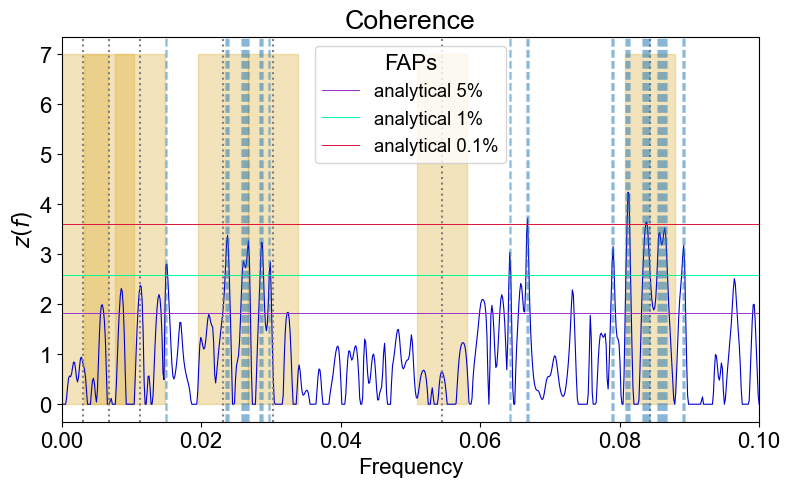

In [52]:
rv_logr.coh_plot(transformed=True, vlines=planets, show_theoretical_thresholds=True, show_boot_thresholds=False)

rayleigh = 0.003574
for i in planets:
    plt.fill_between([i - rayleigh, i + rayleigh], [0,0], [7, 7], color='goldenrod', alpha=0.3)

plt.xlim(0, 0.1)

# Finding peaks above a FAP threshold of 1%
x = rv_logr.pow_coh_grid
y = rv_logr.coh_transformed

prob1 = Bi.ztrans(rv_logr.coh_prob_1, rv_logr.Nseg_eff) # Change the coh_prob_x depending on FAP probability threshold
peak1 = x[y > prob1]
filtered_peaks1 = peak1[peak1 <= 0.1]


for i in filtered_peaks1:
    plt.axvline(i, alpha=0.3, ls='--')

np.set_printoptions(suppress=True)
print(filtered_peaks1)

# To save array with peaks into a file
df = pd.DataFrame(filtered_peaks1)
df.to_csv("rv_logr_realistic_prob1_4segs.csv", index=False, header=False)

Half bandwidth: 0.001282
Welch average spectral window not saved to file
Half bandwidth: 0.001282
Welch average spectral window not saved to file


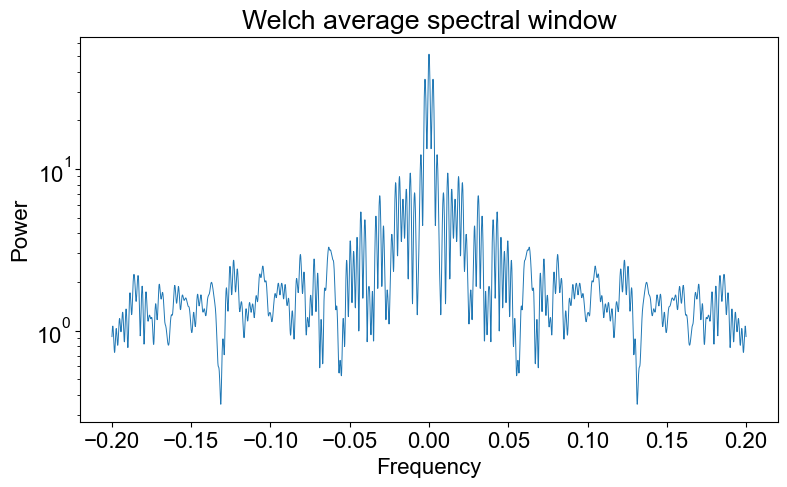

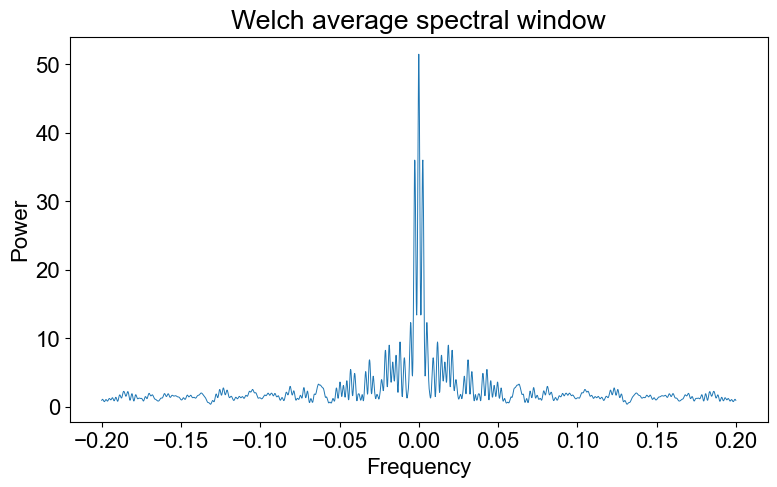

In [53]:
rv_logr.x_series.spectral_window_Welch()
rv_logr.x_series.spectral_window_Welch(yscale='linear')

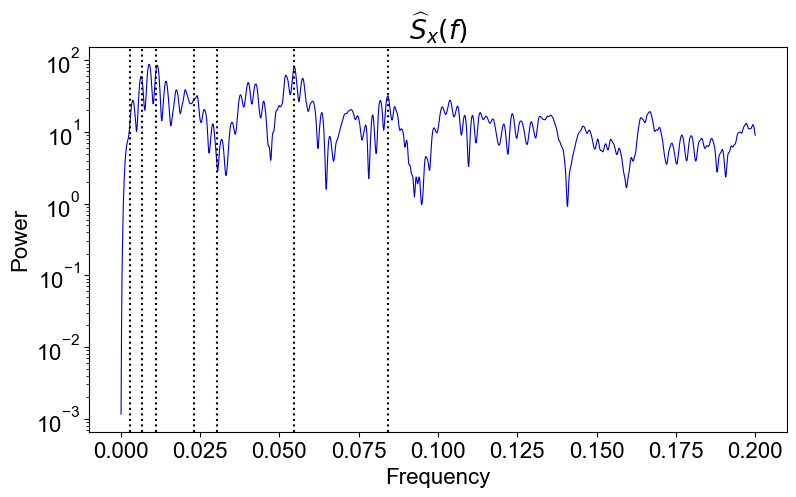

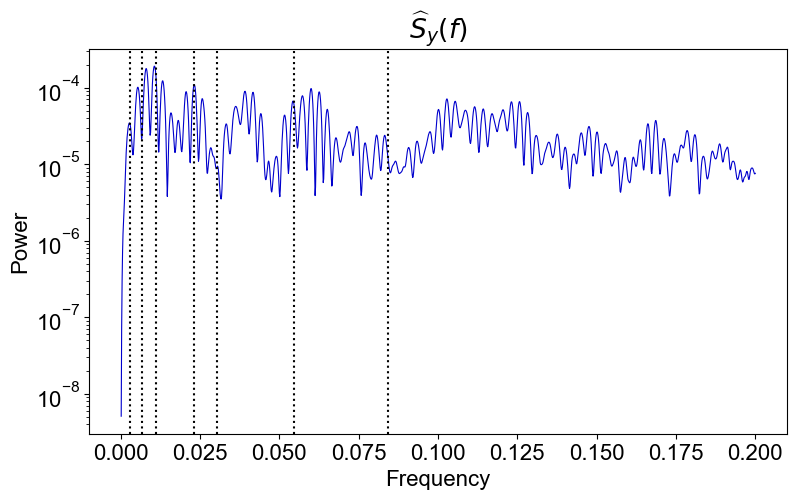

In [54]:
rv_logr.Welch_pow_plot(vlines=planets)
rv_logr.Welch_pow_plot(x_or_y='y', vlines=planets)

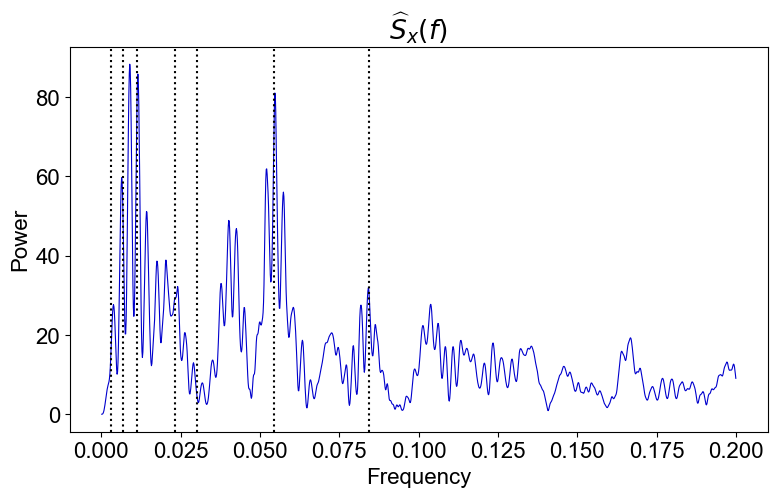

In [55]:
rv_logr.Welch_pow_plot(vlines=planets, yscale='linear')

In [56]:
pow_logr = LombScargle(data['RJD'].to_numpy(), data["logR'(HK)"].to_numpy(), normalization='psd').power(rv_logr.pow_coh_grid)
pow_rv = LombScargle(data['RJD'].to_numpy(), data['RV'].to_numpy(), normalization='psd').power(rv_logr.pow_coh_grid)

/Users/andrewandmatthewfonseca/anaconda3/lib/python3.10/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:102: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))


In [57]:
frot_measured = rv_logr.y_series.Welch_powgrid[np.argmax(rv_logr.y_series.Welch_pow)]
print('Measured rotation period:', 1/frot_measured)

Measured rotation period: 94.86486486486478


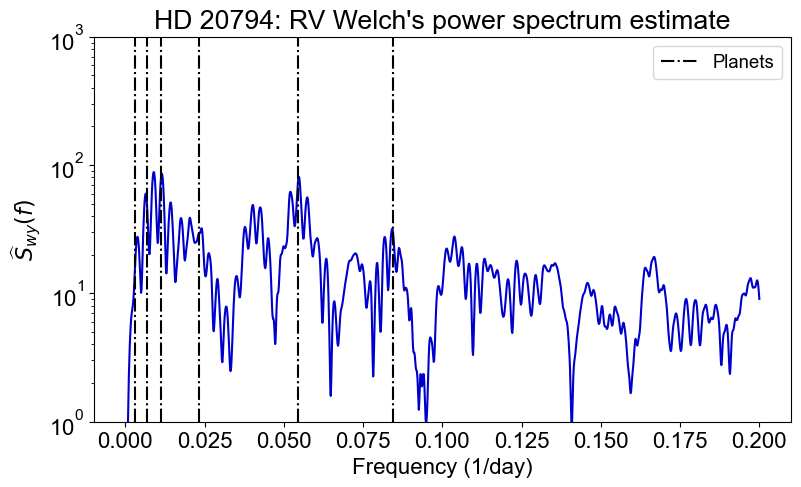

In [58]:
plt.figure(figsize=figsize)
plt.semilogy(rv_logr.pow_coh_grid, rv_logr.x_series.Welch_pow, color='mediumblue')
#plt.axhline(rv_ha.xpow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
#plt.axhline(rv_ha.xpow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
#plt.axhline(rv_ha.xpow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')

for n in range(6):
    if n == 0:
        plt.axvline(planets[n], color='k', ls='-.', label='Planets')
    else:
        plt.axvline(planets[n], color='k', ls='-.')
        
    
plt.ylim(1, 1e3)    
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wy}(f)$")
plt.title(r"HD 20794: RV Welch's power spectrum estimate")
plt.legend(loc='upper right', fontsize='small')

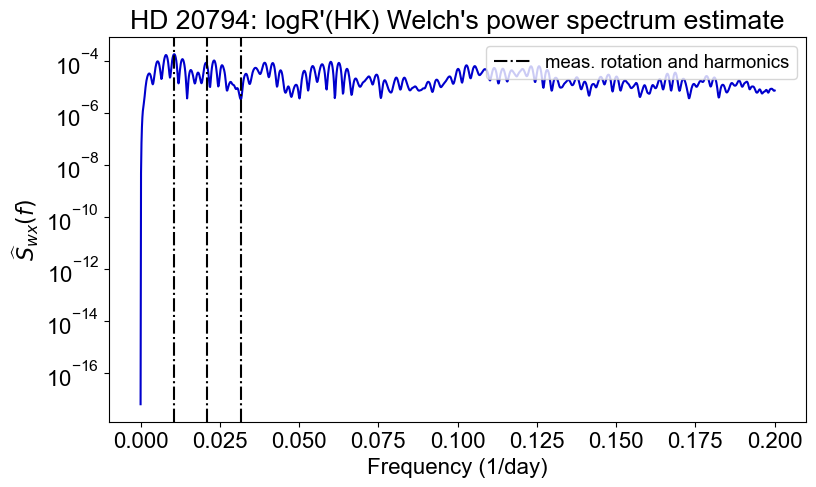

In [59]:
plt.figure(figsize=figsize)
plt.semilogy(rv_logr.pow_coh_grid, rv_logr.y_series.Welch_pow, color='mediumblue')
#plt.axhline(rv_logr.ypow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%')
#plt.axhline(rv_logr.ypow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
#plt.axhline(rv_logr.ypow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')

for s in [frot_measured, 2*frot_measured]:
    plt.axvline(s, color='k', ls='-.')

plt.axvline(3*frot_measured, color='k', ls='-.', label='meas. rotation and harmonics')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wx}(f)$")
plt.title(r"HD 20794: logR'(HK) Welch's power spectrum estimate")
plt.legend(loc='upper right', fontsize='small')